In [1]:
Sys.setlocale(category = "LC_ALL", locale = "en_US.UTF-8")

[1] "en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/C"

# Dependencies

In [2]:
pacman::p_load(dplyr, ggplot2, ggbeeswarm, ggpubr, ggsignif, cowplot, ggh4x, ggrepel)

# Functions

In [3]:
calculate_delta.fx <- function(df, var1, var2) {
    # make a tbale patient x var1
    mytab <- table(df$Patient, df[[var1]])
    # min two samples per patient
    mytab <- mytab[rowSums(mytab == 1) > 1, ]
    # select those samples with a baseline
    baseline_patients <- rownames(mytab)[mytab[, 1] == 1]
    df1 <- df[df$Patient %in% baseline_patients, ]
    result <- df1 %>%
        group_by(Patient) %>%
        mutate(Difference = eval(parse(text = var2)) - eval(parse(text = var2))[eval(parse(text = var1)) == "X01"])
    return(result)
}


In [4]:
delta_basespiderplot.fx <- function(df_diff, var1, clrby, colpal) {
    # df_diff from calculate_delta.fx
    p0 <- ggplot(
        df_diff,
        aes(x = eval(parse(text = var1)), y = Difference)
    ) +
        geom_point(aes(color = eval(parse(text = clrby))), cex = 2) +
        geom_line(aes(group = Patient, color = eval(parse(text = clrby)))) +
        scale_color_manual(values = colpal) +
        myplot +
        myaxis +
        theme(
            axis.text.x = element_text(angle = 45, hjust = 1),
            axis.title.x = element_blank()
        )
    return(p0)
}


In [5]:
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/color_schemes.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/Misc_functions.R")

# Paths

In [6]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [7]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/"

# Main

In [8]:
meta_div1 <- readr::read_rds(paste0(datapath, "capTCRseq/meta_div_goodsamples.rds"))

In [9]:
meta_div <- meta_div1[ !is.na(meta_div1$TRB), ]

In [10]:
meta_div <- meta_div[ meta_div$cancergroup != "Normal", ]
meta_div <- meta_div[ meta_div$cancergroup != "LFS", ]

Separate PBMC and cfDNA

In [12]:
pbmc <- meta_div[ which(meta_div$sampletype == "PBMC"),]
cfdna <- meta_div[ which(meta_div$sampletype == "cfDNA"),]

## Change relative to with baseline

### PBMC

In [13]:
# dd <- datadist(pbmc[ , c("cycle", "cancergroup", "Age", "log10shann") ])
# options(datadist="dd")

In [14]:
# f <- ols(log10shann ~ cycle + cancergroup + Age, data = pbmc)

In [15]:
# pbmc$resi <- f$residuals

In [16]:
diff_log10shann <- calculate_delta.fx(pbmc, "cycle", "log10shann")

In [17]:
summary(diff_log10shann$Difference[diff_log10shann$Difference != 0])

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-2.04107 -0.28076  0.05019  0.19120  0.60576  2.01922 

In [198]:
# 25% 75% intercepts
myintercepts <- quantile(diff_log10shann$Difference[diff_log10shann$Difference != 0], c(0.25, 0.75) )

In [206]:
p0 <- delta_basespiderplot.fx(diff_log10shann, "cycle", "cancergroup", group_col)

In [207]:
p0 <- p0 + geom_hline(yintercept = myintercepts, linetype = "dashed", color = "grey")

In [208]:
# get the last timepoint for each patient
last_timepoint <- diff_log10shann %>%
    group_by(Patient) %>%
    filter(cycle == max(cycle))

In [209]:
last_timepoint$cycleno <- as.numeric(gsub("X0", "", last_timepoint$cycle) )

In [210]:
p0 <- p0 + geom_text_repel(
    data = last_timepoint,
    aes(label = Disease_type),
    hjust = "left",
    direction = "y",
    nudge_x = 6.5 - last_timepoint$cycleno,
    size = 3,
    xlim = c(6, NA),
    segment.color = NA
) + facet_wrap(~cancergroup, nrow = 1)


In [212]:
pdf(paste0(plotpath, "delta_shann_cancergroup_facet.pdf"), width = 10, height = 6)
p0 + theme(legend.position = "none")+ 
theme(strip.background = element_blank(),
          strip.text = element_text(size = 15),
          strip.placement = "outside",
          panel.border = element_rect(color = "black", fill = NA, size = 0.5)) +
          ylab("Change in TCR diversity") +
          scale_x_discrete(get_breaks("cycle"), labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5"), expand = expansion(mult = c(0.1,0.8)))
dev.off()

pdf 
  2

### cfDNA

In [218]:
diff_log10shann_cfdna <- calculate_delta.fx(cfdna, "cycle", "log10shann")

In [219]:
# 25% 75% intercepts
myintercepts <- quantile(diff_log10shann_cfdna$Difference[diff_log10shann_cfdna$Difference != 0], c(0.25, 0.75) )

In [220]:
p1 <- delta_basespiderplot.fx(diff_log10shann_cfdna, "cycle", "cancergroup", group_col)

In [221]:
p1 <- p1 + geom_hline(yintercept = myintercepts, linetype = "dashed", color = "grey")

In [222]:
last_timepoint <- diff_log10shann_cfdna %>%
    group_by(Patient) %>%
    filter(cycle == max(cycle))

In [223]:
last_timepoint$cycleno <- as.numeric(gsub("X0", "", last_timepoint$cycle) )

In [224]:
p1 <- p1 + geom_text_repel(
    data = last_timepoint,
    aes(label = Disease_type),
    hjust = "left",
    direction = "y",
    nudge_x = 6.5 - last_timepoint$cycleno,
    size = 3,
    xlim = c(6, NA),
    segment.color = NA,
) + facet_wrap(~cancergroup, nrow = 1)

In [225]:
pdf(paste0(plotpath, "delta_cfDNAshann_cancergroup_facet.pdf"), width = 10, height = 6)
p1 + theme(legend.position = "none") +
    theme(
        strip.background = element_blank(),
        strip.text = element_text(size = 15),
        strip.placement = "outside",
        panel.border = element_rect(color = "black", fill = NA, size = 0.5)
    ) +
    ylab("Change in cfTCR diversity") +
    scale_x_discrete(get_breaks("cycle"), labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5"), expand = expansion(mult = c(0.1, 0.8)))

dev.off()


pdf 
  2

### Flow

In [31]:
pbmc1 <- meta_div[ meta_div$sampletype == "PBMC" & !is.na(meta_div$CD3),]
pbmc1 <- pbmc1[ pbmc1$CD3 > 0,]

In [32]:
mycells <- c("Naïve%", "SCM%", "CM%", "EM%", "TE%", "LAG3%", "TIM3%", "PD1%")

In [33]:
# subset to samples with no NA in `Naïve%`, `CM%`, `EM%`, `TEMRA%`. use apply
# to subset to samples with no NA in any of these columns
pbmc1 <- pbmc1[ apply(pbmc1[ , mycells], 1, function(x) !any(is.na(x)) ), ]

In [34]:
# diff_log10shann <- calculate_delta.fx(pbmc, "cycle", "log10shann")

In [35]:
# p0 <- delta_basespiderplot.fx(diff_log10shann, "cycle", "cancergroup", group_col)

In [36]:
# # get the last timepoint for each patient
# last_timepoint <- diff_log10shann %>%
#     group_by(Patient) %>%
#     filter(cycle == max(cycle))

In [37]:
# p0 <- p0 + geom_text_repel(
#     data = last_timepoint,
#     aes(label = Disease_type),
#     hjust = "right",
#     direction = "y",
#     nudge_x = 3,
#     size = 3,
#     xlim = c(6, NA),
# ) + facet_wrap(~cancergroup, nrow = 1)


In [38]:
# pdf(paste0(plotpath, "delta_shann_cancergroup_facet.pdf"), width = 10, height = 6)
# p0 + theme(legend.position = "none")+ 
# theme(strip.background = element_blank(),
#           strip.text = element_text(size = 15),
#           strip.placement = "outside",
#           panel.border = element_rect(color = "black", fill = NA, size = 0.5)) +
#           ylab("Change in TCR diversity")
# dev.off()

In [39]:
ls()

[1] "addjurkat.fx"            "age_pal"                
 [3] "align_plots1"            "calculate_delta.fx"     
 [5] "cfdna"                   "cohort_col"             
 [7] "cycle_col"               "datapath"               
 [9] "delta_basespiderplot.fx" "diff_log10shann"        
[11] "diff_log10shann_cfdna"   "gitpath"                
[13] "group_col"               "h4hpath"                
[15] "histdenp"                "histp"                  
[17] "last_timepoint"          "manifestpath"           
[19] "message_parallel"        "meta_div"               
[21] "meta_div1"               "myaxis"                 
[23] "mycells"                 "myintercepts"           
[25] "myplot"                  "p0"                     
[27] "p1"                      "pbmc"                   
[29] "pbmc1"                   "plotpath"               
[31] "safe_mclapply"           "text_matrix"            
[33] "type_col"

In [40]:
gg_list <- list()

mycells <- c("`Naïve%`", "`SCM%`", "`CM%`", "`EM%`", "`TE%`", "`LAG3%`", "`TIM3%`", "`PD1%`")

for (i in 1:length(mycells)) {
    pbmc1$grp <- gsub("`", "", mycells[i])
    mydiff <- calculate_delta.fx(pbmc1, "cycle", mycells[i])
    p0 <- delta_basespiderplot.fx(mydiff, "cycle", "cancergroup", group_col)
    # get the last timepoint for each patient
    last_timepoint <- mydiff %>%
        group_by(Patient) %>%
        filter(cycle == max(cycle))

    p0 <- p0 + geom_text_repel(
        data = last_timepoint,
        aes(label = Disease_type),
        hjust = "right",
        direction = "y",
        nudge_x = 3,
        size = 3,
        xlim = c(6, NA),
    ) + # facet_wrap(~cancergroup, nrow = 1)
        # myp <- delta_timeseries_baseplot.fx(pbmc1, "cycle", mycells[i], "cancergroup", group_col) +
        facet_nested(~ grp + cancergroup, nest_line = element_line(linetype = 1), switch = "y", axes = "all", remove_labels = "all") +
        theme(
            axis.title.y = element_blank(),
            strip.background = element_blank(),
            strip.text = element_text(size = 15),
            strip.placement = "outside",
            legend.position = "none",
            panel.border = element_rect(color = "black", fill = NA, size = 0.5),
            ggh4x.facet.nestline = element_line(colour = "black", linewidth = 0.3)
        )

    gg_list[[i]] <- p0
}


In [41]:
allp <- cowplot::plot_grid(plotlist=gg_list, nrow = 2, align = "h")

In [42]:
pdf(paste0(plotpath, "delta_Tcellsubsets_cancergroup_facet.pdf"), width = 24, height = 20)
allp
dev.off()

pdf 
  2

# Backup

## Plots for chemo cycles - paired samples

### PBMC

In [ ]:
mytab <- table(pbmc$Patient, pbmc$cycle)

In [ ]:
paired_patients <- rownames(mytab)[rowSums(mytab == 1) == 5]

In [ ]:
paired_patients

[1] "CHP_347" "CHP_350" "CHP_357" "CHP_405"

In [ ]:
paired_pbmc <- pbmc[ pbmc$Patient %in% paired_patients,]

In [ ]:
# ggplot(paired_pbmc, aes(x= cycle, y= log10shann, group = Patient) ) + 
# facet_grid(Patient ~ ., scales = "free_y") + 
# geom_line()

### cfDNA

In [ ]:
mytab <- table(cfdna$Patient, cfdna$cycle)

In [ ]:
paired_patients <- rownames(mytab)[rowSums(mytab == 1) >= 4]

In [ ]:
paired_cfdna <- cfdna[ cfdna$Patient %in% paired_patients,]

In [ ]:
p_cfdna_paired <- ggplot(
  paired_cfdna,
  aes(x = cycle, y = log10shann)
) +
#  geom_boxplot() + #  
  geom_point(aes(color = cancergroup), cex = 2) +
  geom_line(aes(group = Patient, color = cancergroup)) + 
  scale_color_manual(values= group_col) +
  myplot +
  myaxis +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.title.x = element_blank()
  ) +
  annotation_logticks(sides = "l") +
  scale_y_continuous(breaks = log10(c(1,10,100) ) , labels = c(1,10,100)) +
 # labs(title = "Observed Shannon Diversity by Cycle - PBMC (n = 234)\nBH corrected p", y = "Observed Shannon Diversity") +
  facet_wrap(~cancergroup, nrow = 1)

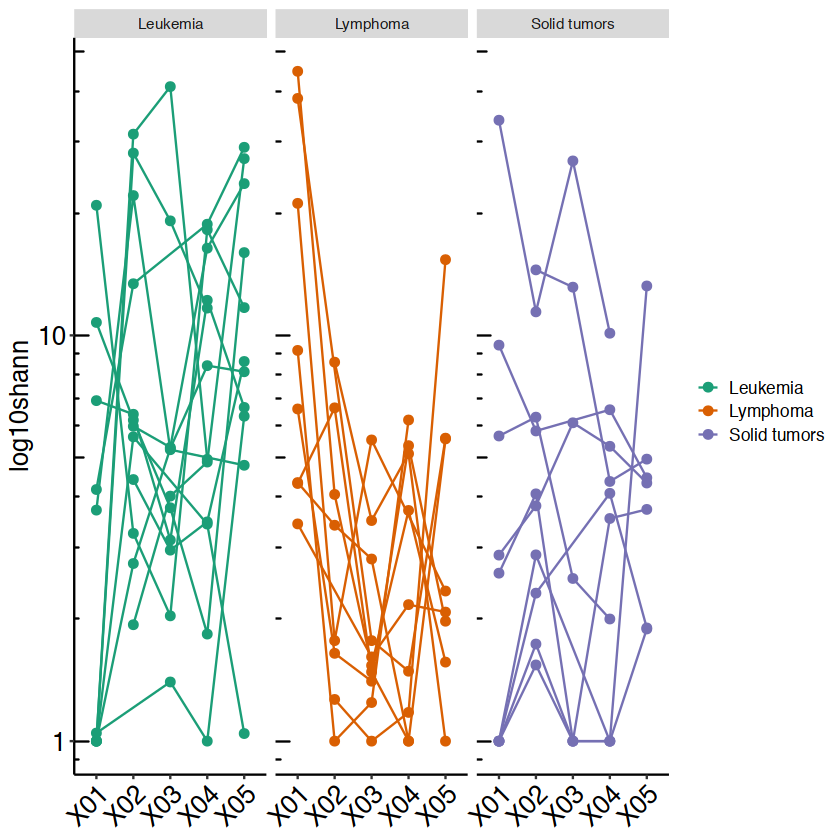

In [ ]:
p_cfdna_paired